## Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import unyt

import os
from glob import glob
from pathlib import Path


from velociraptor.observations import load_observation, load_observations
from swiftemulator.comparison.penalty import L2PenaltyCalculator, GaussianDataErrorsPercentFloorPenaltyCalculator


# For fitting model to data
from scipy.optimize import minimize

import emcee
import corner
import arviz
from scipy.stats import norm


# For loading in emulator
import dill

## Load/calculate all relevant info for each emulator/observable

In [2]:
def emulator_model(x, pred_params, emulator):
    pred_y, pred_var = emulator.predict_values(x, pred_params)
    
    pred_std = np.sqrt(pred_var)
    pred_ccheck_std = np.abs(emulator.model_specification.sigma_ccheck * pred_y)
    pred_total = np.sqrt(pred_std**2 + pred_ccheck_std**2)
    
    return pred_y, pred_ccheck_std

In [25]:
emulator_info = {
    'GSMF':{
        'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_32x_v2/',
        'cali_dir':'calibrations',
        'obs_name':'gsmf_v4_log_data_0015',
        'emulator_type':'emulator',
        'snap_prefix':'simba_s25n256',
        'snap_num':'0015',
        'emulator_dir':'emulators',
        'data_dir':'/home/b/babul/aspadawe/data/observations/gsmf/Bernardi+17/',
        'data_name':'bernardi17_gsmf_log_data',
        'data_choice':'data_lim',
        'use_err':'max',
        'min_x_for_mcmc':10,
        'max_x_for_mcmc':13,
        'plot_sim':{'ls':'--', 'marker':None, 'color':'blue'},
        'plot_emu':{'ls':'-', 'marker':None, 'color':'red'},
        'plot_data':{'ls':'-', 'marker':None, 'color':'black'},
    },
    'Mbh-M*':{
        'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_32x_v2/',
        'cali_dir':'calibrations',
        'obs_name':'bhmsm_v4_binned_log_median_0015',
        'emulator_type':'emulator',
        'snap_prefix':'simba_s25n256',
        'snap_num':'0015',
        'emulator_dir':'emulators',
        'data_dir':'/home/b/babul/aspadawe/data/observations/bhmsm/KormendyHo2013/',
        'data_name':'kh13_bhmsm_log_data',
        'data_choice':'data_lim',
        'use_err':'max',
        'min_x_for_mcmc':10,
        'max_x_for_mcmc':13,
        'plot_sim':{'ls':'--', 'marker':None, 'color':'blue'},
        'plot_emu':{'ls':'-', 'marker':None, 'color':'red'},
        'plot_data':{'ls':'', 'marker':'o', 'color':'black'},
    },
#     'CSFH':{
#         'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_sphenix_32x/',
#         'cali_dir':'calibrations',
#         'obs_name':'csfh_log_data',
#         'emulator_type':'emulator',
#         'snap_prefix':'simba_s25n256',
#         'snap_num':'0015',
#         'emulator_dir':'emulators',
#         'data_dir':'/home/b/babul/aspadawe/data/observations/csfh/MD14/',
#         'data_name':'md14_csfh_log_data',
#         'data_choice':'data_lim',
#         'use_err':'max',
#         'min_x_for_mcmc':-1,
#         'max_x_for_mcmc':5,
#         'plot_sim':{'ls':'--', 'marker':None, 'color':'blue'},
#         'plot_emu':{'ls':'-', 'marker':None, 'color':'red'},
#         'plot_data':{'ls':'', 'marker':'o', 'color':'black'},
#     },
}

In [26]:
# Get all relevant info for each observable
for key, item in emulator_info.items():
    print(key)
    
    # Trained emulator
    with open(os.path.join(item['root_dir'], item['emulator_dir'], item['emulator_type']+'_'+item['obs_name']+'.pkl'), 'rb') as f:
        emulator = dill.load(f)
    item['emulator'] = emulator
    
    # Observational data
    observational_data = load_observations(os.path.join(item['data_dir'], item['data_name']+'.hdf5'))[0]
    item['observational_data'] = observational_data
    
    # Penalty function
    sim_paths = [Path(x) for x in glob(os.path.join(item['root_dir'], item['cali_dir'], 'cali_*', 
                                                    item['snap_prefix']+'_'+item['obs_name']+'_'+item['snap_num']+'.hdf5')) 
                 if os.path.exists(x)]
    item['sim_paths'] = sim_paths
    

    penalty_calculator = GaussianDataErrorsPercentFloorPenaltyCalculator(percent_error=20,
                                                                     sigma_max=3,
                                                                     lower=min(observational_data.x),
                                                                     upper=max(observational_data.x))
    
    x_unit = emulator.model_specification.sim_info['x_units']
    y_unit = emulator.model_specification.sim_info['y_units']

    penalty_calculator.register_observation(observational_data,
                                log_independent=False,
                                log_dependent=False,
                                independent_units=x_unit,
                                dependent_units=y_unit)
    
    item['penalty_calculator'] = penalty_calculator
    
    
    # Get full range of x values that have been used in training emulator
    sim_x = []
    for cali in emulator.model_values.model_values:
        sim_x_curr = emulator.model_values[cali]['independent']
        for x_val in sim_x_curr:
            if x_val not in sim_x:
                sim_x.append(x_val)

    sim_x = np.array(np.sort(sim_x))
    item['sim_x'] = sim_x
    
    
    # Get "limited" range of x values that have been used in training emulator
    # ie. lower and upper limits on x values are ones that are common to all simulations
    sim_x_lim = []
    counter = 0
    for cali, item_ in emulator.model_values.items():
        sim_x_lim_curr = item_['independent']
        if counter==0:
            sim_x_lim = sim_x_lim_curr
        else:
            sim_x_lim = np.intersect1d(sim_x_lim, sim_x_lim_curr)
        counter += 1

    sim_x_lim = np.array(np.sort(sim_x_lim))
    item['sim_x_lim'] = sim_x_lim
    
    
    
    # Get just full range of data
    x = penalty_calculator.observation.x.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]
    
    if item['use_err'] == 'max':
        data_full = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_full = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_full'] = data_full
    
    
    # Separate out data into x, y, yerr
    # Get only data that falls within chosen x range of simulation, but is still original data without interpolation
    x = penalty_calculator.observation.x.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value
    
    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]

    range_condition = np.logical_and(x >= min(sim_x), x <= max(sim_x))
    x = x[range_condition]
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_lim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_lim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_lim'] = data_lim
    
    
    # Separate out data into x, y, yerr
    # Get only data that corresponds to exact chosen x range of simulation
    # (Need to use GaussianDataErrorsPercentFloorPenaltyCalculator to do interpolation for this)
    x = sim_x
    penalty_calculator.observation_interpolation()
    y = penalty_calculator.interpolator_values(x)
    yerr = penalty_calculator.error_interpolator_values(x)  # can only use for certain penalty calculators, eg. GaussianDataErrorsPercentFloorPenaltyCalculator

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr
        
    range_condition = np.logical_and(sim_x >= min(penalty_calculator.observation.x.value), 
                                     sim_x <= max(penalty_calculator.observation.x.value))
    x = x[range_condition]  # limit to within range of observational data
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_interp = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_interp = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_interp'] = data_interp
    
    
    
    # Choose which data to use for MCMC
    try:
        data_choice = item[item['data_choice']]
    except:
        print('Invalid data choice')
        break
    range_condition = np.logical_and(data_choice[0] >= item['min_x_for_mcmc'], 
                                     data_choice[0] <= item['max_x_for_mcmc'])
    x = data_choice[0][range_condition]
    y = data_choice[1][range_condition]
    yerr = data_choice[2][range_condition]
    
    data_for_mcmc = (x, y, yerr)
    item['data_for_mcmc'] = data_for_mcmc
    
    
    
    # Get full x range of both simulation and observational data
    x_lo_full = min(min(sim_x), min(data_full[0]))
    x_hi_full = max(max(sim_x), max(data_full[0]))
    
    N_full = 100
    x_full = np.linspace(x_lo_full, x_hi_full, N_full)
    item['x_full'] = x_full
    
    
    
    # Check which input simulation best fits the observational data
    all_penalties = penalty_calculator.penalties(emulator.model_values, np.mean)

    all_penalties_array = []
    node_number = []
    for key_penalty in all_penalties.keys():
        all_penalties_array.append(all_penalties[key_penalty])
        node_number.append(key_penalty)

    best_node = node_number[np.argmin(all_penalties_array)]
    params_best_node = emulator.model_parameters[best_node].copy()
    
    item['best_node'] = best_node
    item['params_best_node'] = params_best_node
    
    
    # Get min and max values of each parameter that go into original simulations
    # They will be the MCMC parameter limits
    param_mins_arr = []
    param_maxs_arr = []
    param_mins = {}
    param_maxs = {}
    
    for param_, param_limits_ in zip(emulator.model_specification.parameter_names, emulator.model_specification.parameter_limits):
        param_mins_arr.append(param_limits_[0])
        param_maxs_arr.append(param_limits_[1])
        param_mins[param_] = param_limits_[0]
        param_maxs[param_] = param_limits_[1]
    param_mins_arr = np.array(param_mins_arr, float)
    param_maxs_arr = np.array(param_maxs_arr, float)
        
    # If you want to specify other flat parameter priors for the MCMC
#     param_mins_arr = [0.5, 5.0, 0.00001, 6.5]
#     param_maxs_arr = [5.0, 13.0, 0.008, 8.0]
    
    item['param_mins'] = param_mins
    item['param_maxs'] = param_maxs
    item['param_mins_arr'] = param_mins_arr
    item['param_maxs_arr'] = param_maxs_arr

GSMF
Mbh-M*


In [27]:
emulator_info

{'GSMF': {'root_dir': '/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_32x_v2/',
  'cali_dir': 'calibrations',
  'obs_name': 'gsmf_v4_log_data_0015',
  'emulator_type': 'emulator',
  'snap_prefix': 'simba_s25n256',
  'snap_num': '0015',
  'emulator_dir': 'emulators',
  'data_dir': '/home/b/babul/aspadawe/data/observations/gsmf/Bernardi+17/',
  'data_name': 'bernardi17_gsmf_log_data',
  'data_choice': 'data_lim',
  'use_err': 'max',
  'min_x_for_mcmc': 10,
  'max_x_for_mcmc': 13,
  'plot_sim': {'ls': '--', 'marker': None, 'color': 'blue'},
  'plot_emu': {'ls': '-', 'marker': None, 'color': 'red'},
  'plot_data': {'ls': '-', 'marker': None, 'color': 'black'},
  'emulator': GaussianProcessEmulator(kernel=ConstantKernel(log_constant=-1.3862943611198906, ndim=4, axes=array([0, 1, 2, 3])) * ExpSquaredKernel(metric=Metric(array([1., 1., 1., 1.]), ndim=4, axes=array([0, 1, 2, 3]), bounds=[(None, None), (None, None), (None, None), (None, None)]), block=N

## Run joint MCMC on all models/observational data

In [28]:
def model(theta, x, emulator):
    params = emulator.model_parameters[best_node].copy()

    for ii in range(len(theta)):
        key = list(params.keys())[ii]
        params[key] = theta[ii]

    val, err = emulator_model(x, params, emulator)
    return val, err


def lnlike(theta, emulator_info):
    LnLike_val = 0
    for key, item in emulator_info.items():
        data = item['data_for_mcmc']
        x = data[0]
        y = data[1]
        yerr = data[2]
        m, merr = model(theta, x, item['emulator'])
        
        ## Different likelihood function choices depending on what you want

    #    LnLike = sum(norm.logpdf(y, loc=m, scale=yerr))  # One way to get LnLike with scipy.stats
        LnLike = -0.5 * sum(np.power((y - m)*np.power(yerr,-1), 2))  # Get likelihood (assuming indepenent Gaussian error bars?)

    #    LnLike = -0.5 * np.sum(np.power((y - m), 2))  # If no error bars on data
    #    LnLike = -np.sum((y - m)**2 / 0.5**2)
    
        
        # Likelihood from Kugel+23 (eqn 21/22/24)
#         LnLike_ = -(y - m)**2 / (yerr**2 + merr**2)
#         LnLike = np.sum(LnLike_) / len(x)
    
    
        LnLike_val += LnLike
    
    return LnLike_val


def within_limits(theta, emulator_info):
    result = True
    for key, item in emulator_info.items():
        for ii in range(len(theta)):
            result = result and (item['param_mins_arr'][ii] <= theta[ii] and theta[ii] <= item['param_maxs_arr'][ii])
    return result

def lnprior(theta, emulator_info):
    if within_limits(theta, emulator_info):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, emulator_info):
    lp = lnprior(theta, emulator_info)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, emulator_info)  # if lp not -inf, its 0, so this just returns likelihood

In [29]:
# Get initial estimate of parameters from scipy optimizer
np.random.seed(42)
nll = lambda *args: -lnlike(*args)

initial_opt = np.zeros(len(emulator_info[list(emulator_info.keys())[0]]['params_best_node'].values()))
opt_count = 0
for key, item in emulator_info.items():
    opt_count += 1
    initial_opt += np.array(list(item['params_best_node'].values()))
initial_opt /= opt_count
print(initial_opt)

soln = minimize(nll, initial_opt, args=emulator_info)
print(soln)

[3.61490385e+00 3.08464528e-03 8.03433245e+00]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 9958.549643091292
        x: [ 3.615e+00 -2.782e-04  8.034e+00]
      nit: 6
      jac: [ 0.000e+00  1.233e-02  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00  0.000e+00]
            [ 0.000e+00  7.234e-11  0.000e+00]
            [ 0.000e+00  0.000e+00  1.000e+00]]
     nfev: 260
     njev: 62


In [30]:
# Parameters for MCMC run
if within_limits(soln.x, emulator_info):
    initial_mcmc = soln.x
else:
    initial_mcmc = initial_opt
print(initial_mcmc)
ndim = len(initial_mcmc)
niter = 100
nwalkers = 32
p0 = [np.array(initial_mcmc) + (-1)**i * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

[3.61490385e+00 3.08464528e-03 8.03433245e+00]


In [31]:
print("Prior lower bounds:", emulator_info[list(emulator_info.keys())[0]]['param_mins'])
print("Prior upper bounds:", emulator_info[list(emulator_info.keys())[0]]['param_maxs'])

Prior lower bounds: {'SIMBAFeedback:FIRE_velocity_normalization': 0.6401378437843689, 'SIMBAAGN:torque_accretion_norm': 0.0002164209037335866, 'SIMBAAGN:jet_mass_min_Msun': 7.012643247264345}
Prior upper bounds: {'SIMBAFeedback:FIRE_velocity_normalization': 4.883504703041088, 'SIMBAAGN:torque_accretion_norm': 0.009991574424000815, 'SIMBAAGN:jet_mass_min_Msun': 8.975325972526619}


In [32]:
# Function for running production iterations of MCMC
def main(p0, nwalkers, niter, ndim, lnprob, emulator_info):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=emulator_info)

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)
    print("Done")

    return sampler, pos, prob, state

In [33]:
# Execute MCMC
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, [emulator_info])

Running production...


100%|██████████| 100/100 [00:03<00:00, 26.89it/s]

Done


Text(0.5, 0, 'step number')

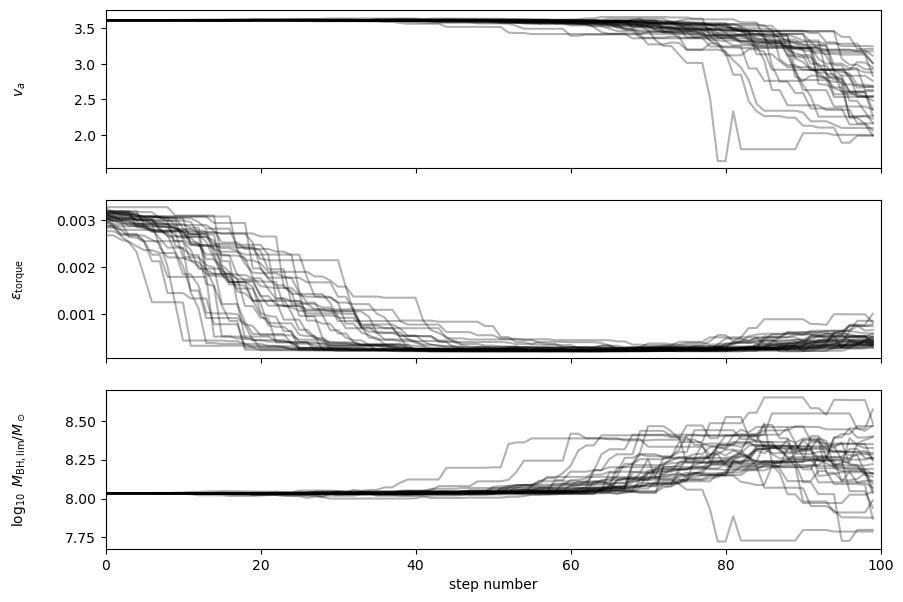

In [34]:
# Plot MCMC chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = emulator_info[list(emulator_info.keys())[0]]['emulator'].model_specification.parameter_printable_names
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [35]:
acc = sampler.acceptance_fraction
print("Mean acceptance fraction = %s" % np.mean(acc))

Mean acceptance fraction = 0.400625


In [36]:
# Get autocorrelation time to determine burn-in required
tau = sampler.get_autocorr_time(quiet=True)
print(tau)

N/50 = 2;
tau: [11.76209801 11.6147294  11.85643141]


[11.76209801 11.6147294  11.85643141]


In [37]:
# Remove burn-in
# nburn = int(np.mean(tau))
# print(nburn)

# Can also just make burn-in X percent of number of iterations
x_percent = 0.1
nburn = int(x_percent * niter)
print(nburn)

#thin_val = int(nburn/100)
thin_val = 1

flat_samples = sampler.get_chain(discard=nburn, thin=thin_val, flat=True)

10


In [38]:
# Posterior parameters with highest probability
theta_max_arr = flat_samples[np.argmax(sampler.get_log_prob(discard=nburn, thin=thin_val, flat=True))]
print(theta_max_arr)

[1.99891359e+00 4.36798024e-04 7.78729260e+00]


GSMF



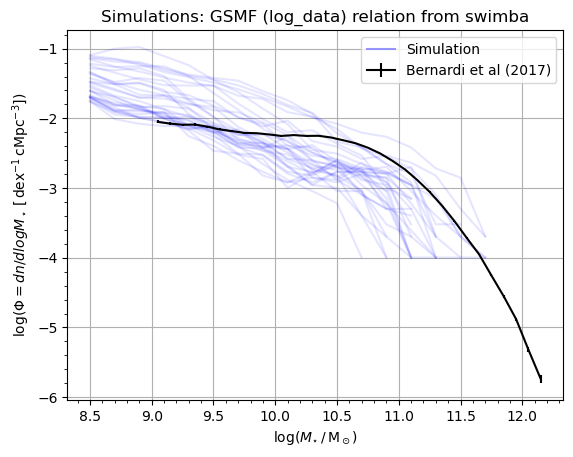

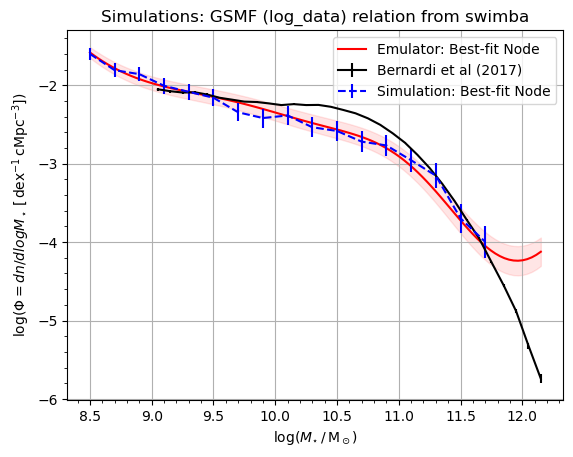

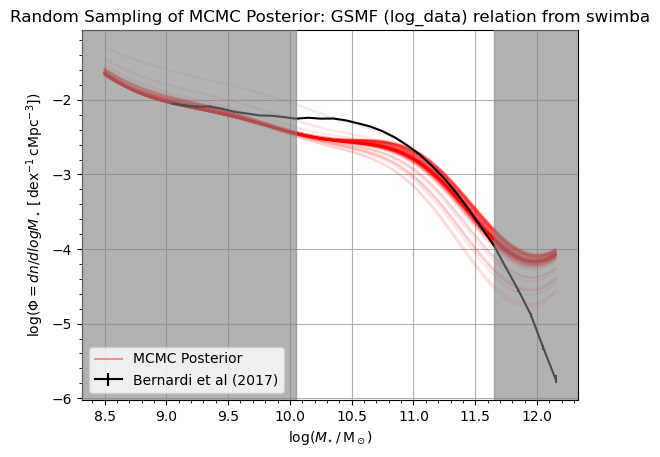

Theta max:  {'SIMBAFeedback:FIRE_velocity_normalization': 1.9989135903461395, 'SIMBAAGN:torque_accretion_norm': 0.00043679802432746844, 'SIMBAAGN:jet_mass_min_Msun': 7.787292600761248}


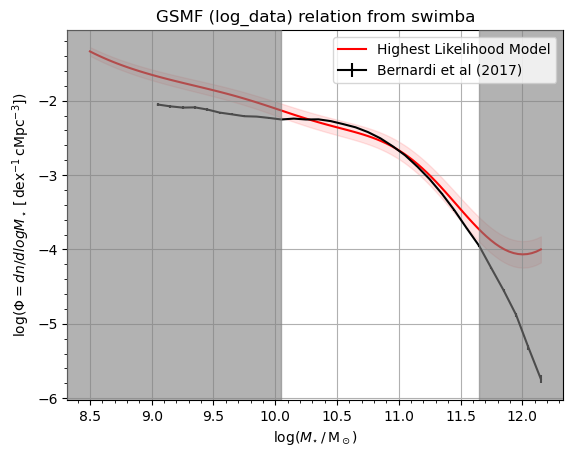




Mbh-M*



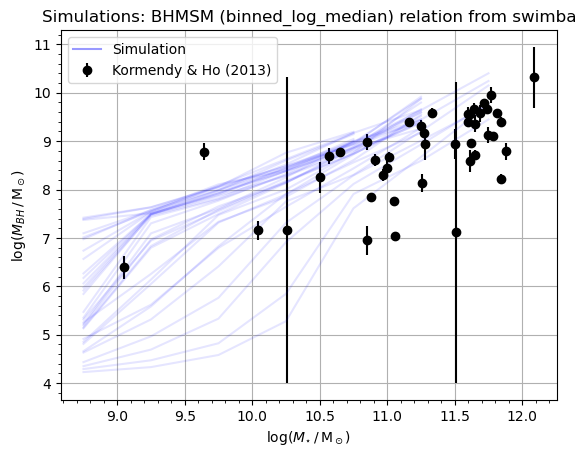

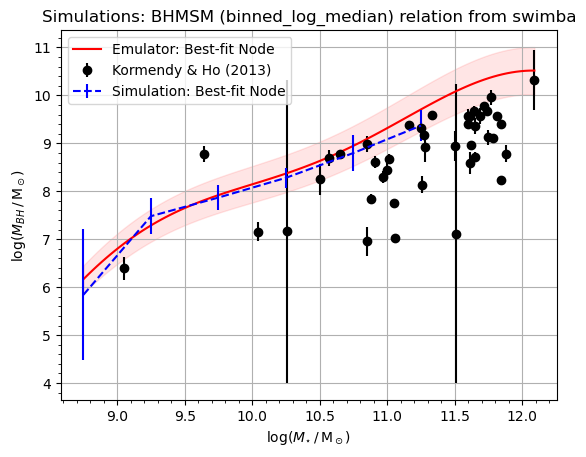

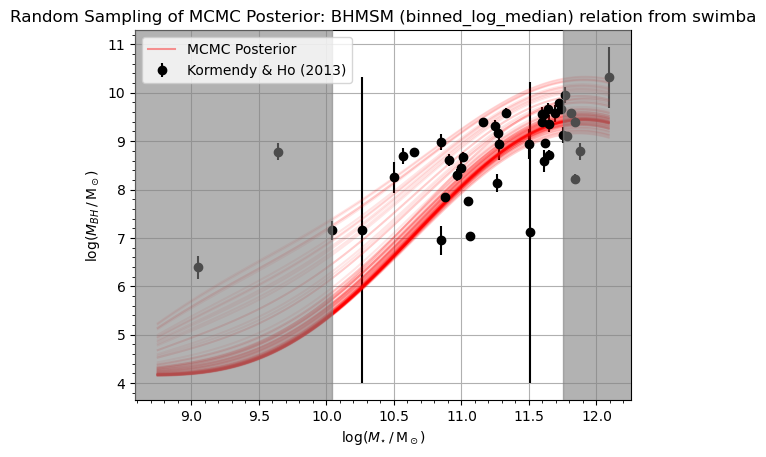

Theta max:  {'SIMBAFeedback:FIRE_velocity_normalization': 1.9989135903461395, 'SIMBAAGN:torque_accretion_norm': 0.00043679802432746844, 'SIMBAAGN:jet_mass_min_Msun': 7.787292600761248}


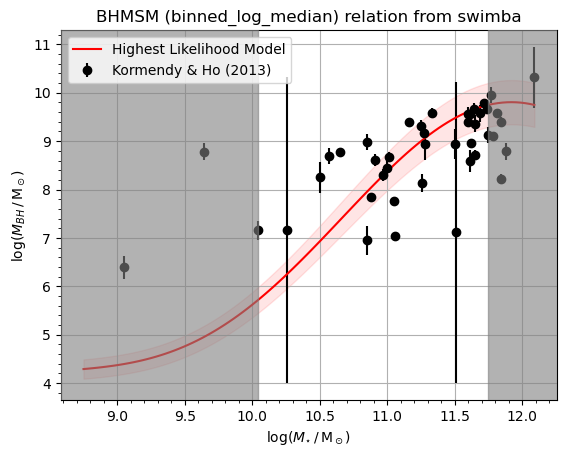

In [39]:
shade_intensity = 0.6
zorder = 4

for key, item in emulator_info.items():
    print(key)
    print()
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']
    
    
    # Plot simulated observables over observational data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
        
    for cali, cali_item in item['emulator'].model_values.items():
        sim_x_cali = cali_item['independent']
        sim_y_cali = cali_item['dependent']

        plt.plot(sim_x_cali, sim_y_cali,
                 ls='-', marker=item['plot_sim']['marker'], color=item['plot_sim']['color'], alpha=0.1)

    plt.plot([],[], color=item['plot_sim']['color'], alpha=0.4, label='Simulation')
    
    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Plot best-fit simulation node over observational data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
#     plt.errorbar(item['data_lim'][0], item['data_lim'][1], yerr=item['data_lim'][2], 
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                  label=item['observational_data'].citation)
    
    pred_y, pred_err = emulator_model(pred_x, item['params_best_node'], item['emulator'])
#     plt.errorbar(pred_x, pred_y, yerr=pred_err, ls='-', label='Emulator: Best-fit Node')
    plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node', 
             color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
    plt.errorbar(item['emulator'].model_values[item['best_node']]['independent'], 
                 item['emulator'].model_values[item['best_node']]['dependent'],
                 item['emulator'].model_values[item['best_node']]['dependent_error'],
                 label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
                 ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    
    # Extract random sampling of posteriors and plot over data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
    
    for theta in flat_samples[np.random.randint(len(flat_samples), size=100)]:
        pred_mcmc, pred_mcmc_err = model(theta, pred_x, item['emulator'])
        plt.plot(pred_x, pred_mcmc, color=item['plot_emu']['color'], 
                 ls='-', marker=item['plot_emu']['marker'], alpha=0.1)

    plt.plot([],[], color=item['plot_emu']['color'], alpha=0.4, label='MCMC Posterior')
    
    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Random Sampling of MCMC Posterior: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Posterior parameters with highest probability
    best_fit_model, best_fit_model_err = model(theta_max_arr, pred_x, item['emulator'])

    theta_max = {}
    for param in emulator.parameter_order:
        idx = item['emulator'].parameter_order.index(param)
        theta_max[param] = theta_max_arr[idx]
    
    item['theta_max_arr'] = theta_max_arr
    item['theta_max'] = theta_max
    print ('Theta max: ', theta_max)
    
    
    
    # Plot best-fit model over data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
    
#     plt.errorbar(pred_x, best_fit_model, yerr=best_fit_model_err,
#                  color="r", alpha=1, label='Highest Likelihood Model')
    plt.plot(pred_x, best_fit_model, label='Highest Likelihood Model', 
             color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    plt.fill_between(pred_x, best_fit_model-best_fit_model_err, best_fit_model+best_fit_model_err, 
                     alpha=0.1, color=item['plot_emu']['color'])

    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title( item['emulator'].model_specification.sim_info['name'])
    
#     if key=='CSFH':
#         plt.ylim(-3, 0)
    
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    print()
    print()
    print()

Quantiles:
[(0.16, 3.3086844387415546), (0.5, 3.6038021101891493), (0.84, 3.6155361100838723)]
Quantiles:
[(0.16, 0.00023548971529877398), (0.5, 0.00029697171914222286), (0.84, 0.0009601528382693199)]
Quantiles:
[(0.16, 8.032463901910676), (0.5, 8.04420232673181), (0.84, 8.26282525557694)]


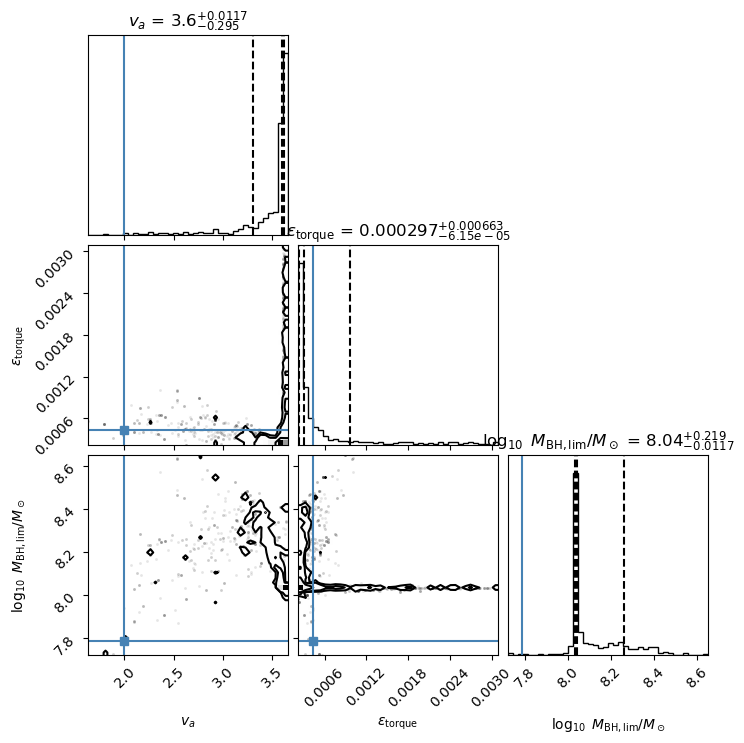

In [40]:
# Corner plot
labels = emulator_info[list(emulator_info.keys())[0]]['emulator'].model_specification.parameter_printable_names
fig = corner.corner(flat_samples, bins=40, hist_bin_factor=1, group='posterior', divergences=False, show_titles=True,
                    title_fmt='.3g', labels=labels, plot_datapoints=True, quantiles=[0.16,0.5,0.84],
                    title_quantiles=[0.16,0.5,0.84], smooth=0., verbose=True, use_math_text=True, reverse=False, 
                    truths=emulator_info[list(emulator_info.keys())[0]]['theta_max_arr'])

# Plot best fit results from observables (that have emulators) not included in above calibration

In [41]:
emulator_info_extra = {
#     'GSMF':{
#         'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_sphenix_32x/',
#         'cali_dir':'calibrations',
#         'obs_name':'gsmf_v4_log_data_0015',
#         'emulator_type':'emulator',
#         'snap_prefix':'simba_s25n256',
#         'snap_num':'0015',
#         'emulator_dir':'emulators',
#         'data_dir':'/home/b/babul/aspadawe/data/observations/gsmf/Bernardi+17/',
#         'data_name':'bernardi17_gsmf_log_data',
#         'data_choice':'data_lim',
#         'use_err':'max',
#         'min_x_for_mcmc':10,
#         'max_x_for_mcmc':13,
#         'plot_sim':{'ls':'--', 'marker':None, 'color':'blue'},
#         'plot_emu':{'ls':'-', 'marker':None, 'color':'red'},
#         'plot_data':{'ls':'-', 'marker':None, 'color':'black'},
#     },
#     'Mbh-M*':{
#         'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_sphenix_32x/',
#         'cali_dir':'calibrations',
#         'obs_name':'bhmsm_v4_binned_log_median_0015',
#         'emulator_type':'emulator',
#         'snap_prefix':'simba_s25n256',
#         'snap_num':'0015',
#         'emulator_dir':'emulators',
#         'data_dir':'/home/b/babul/aspadawe/data/observations/bhmsm/KormendyHo2013/',
#         'data_name':'kh13_bhmsm_log_fit_og',
#         'data_choice':'data_interp',
#         'use_err':'max',
#         'min_x_for_mcmc':10,
#         'max_x_for_mcmc':13,
#         'plot_sim':{'ls':'--', 'marker':None, 'color':'blue'},
#         'plot_emu':{'ls':'-', 'marker':None, 'color':'red'},
#         'plot_data':{'ls':'-', 'marker':None, 'color':'black'},
#     },
    'CSFH':{
        'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_32x_v2/',
        'cali_dir':'calibrations',
        'obs_name':'csfh_log_data',
        'emulator_type':'emulator',
        'snap_prefix':'simba_s25n256',
        'snap_num':'0015',
        'emulator_dir':'emulators',
        'data_dir':'/home/b/babul/aspadawe/data/observations/csfh/MD14/',
        'data_name':'md14_csfh_log_data',
        'data_choice':'data_lim',
        'use_err':'max',
        'min_x_for_mcmc':-1,
        'max_x_for_mcmc':5,
        'plot_sim':{'ls':'--', 'marker':None, 'color':'blue'},
        'plot_emu':{'ls':'-', 'marker':None, 'color':'red'},
        'plot_data':{'ls':'', 'marker':'o', 'color':'black'},
    },
}

In [42]:
# Get all relevant info for each observable
for key, item in emulator_info_extra.items():
    print(key)
    
    # Trained emulator
    with open(os.path.join(item['root_dir'], item['emulator_dir'], item['emulator_type']+'_'+item['obs_name']+'.pkl'), 'rb') as f:
        emulator = dill.load(f)
    item['emulator'] = emulator
    
    # Observational data
    observational_data = load_observations(os.path.join(item['data_dir'], item['data_name']+'.hdf5'))[0]
    item['observational_data'] = observational_data
    
    # Penalty function
    sim_paths = [Path(x) for x in glob(os.path.join(item['root_dir'], item['cali_dir'], 'cali_*', 
                                                    item['snap_prefix']+'_'+item['obs_name']+'_'+item['snap_num']+'.hdf5')) 
                 if os.path.exists(x)]
    item['sim_paths'] = sim_paths
    

    penalty_calculator = GaussianDataErrorsPercentFloorPenaltyCalculator(percent_error=20,
                                                                     sigma_max=3,
                                                                     lower=min(observational_data.x),
                                                                     upper=max(observational_data.x))
    
    x_unit = emulator.model_specification.sim_info['x_units']
    y_unit = emulator.model_specification.sim_info['y_units']

    penalty_calculator.register_observation(observational_data,
                                log_independent=False,
                                log_dependent=False,
                                independent_units=x_unit,
                                dependent_units=y_unit)
    
    item['penalty_calculator'] = penalty_calculator
    
    
    # Get full range of x values that have been used in training emulator
    sim_x = []
    for cali in emulator.model_values.model_values:
        sim_x_curr = emulator.model_values[cali]['independent']
        for x_val in sim_x_curr:
            if x_val not in sim_x:
                sim_x.append(x_val)

    sim_x = np.array(np.sort(sim_x))
    item['sim_x'] = sim_x
    
    
    # Get "limited" range of x values that have been used in training emulator
    # ie. lower and upper limits on x values are ones that are common to all simulations
    sim_x_lim = []
    counter = 0
    for cali, item_ in emulator.model_values.items():
        sim_x_lim_curr = item_['independent']
        if counter==0:
            sim_x_lim = sim_x_lim_curr
        else:
            sim_x_lim = np.intersect1d(sim_x_lim, sim_x_lim_curr)
        counter += 1

    sim_x_lim = np.array(np.sort(sim_x_lim))
    item['sim_x_lim'] = sim_x_lim
    
    
    
    # Get just full range of data
    x = penalty_calculator.observation.x.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]
    
    if item['use_err'] == 'max':
        data_full = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_full = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_full'] = data_full
    
    
    # Separate out data into x, y, yerr
    # Get only data that falls within chosen x range of simulation, but is still original data without interpolation
    x = penalty_calculator.observation.x.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value
    
    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]

    range_condition = np.logical_and(x >= min(sim_x), x <= max(sim_x))
    x = x[range_condition]
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_lim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_lim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_lim'] = data_lim
    
    
    # Separate out data into x, y, yerr
    # Get only data that corresponds to exact chosen x range of simulation
    # (Need to use GaussianDataErrorsPercentFloorPenaltyCalculator to do interpolation for this)
    x = sim_x
    penalty_calculator.observation_interpolation()
    y = penalty_calculator.interpolator_values(x)
    yerr = penalty_calculator.error_interpolator_values(x)  # can only use for certain penalty calculators, eg. GaussianDataErrorsPercentFloorPenaltyCalculator

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr
        
    range_condition = np.logical_and(sim_x >= min(penalty_calculator.observation.x.value), 
                                     sim_x <= max(penalty_calculator.observation.x.value))
    x = x[range_condition]  # limit to within range of observational data
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_interp = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_interp = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_interp'] = data_interp
    
    
    
    # Choose which data to use for MCMC
    try:
        data_choice = item[item['data_choice']]
    except:
        print('Invalid data choice')
        break
    range_condition = np.logical_and(data_choice[0] >= item['min_x_for_mcmc'], 
                                     data_choice[0] <= item['max_x_for_mcmc'])
    x = data_choice[0][range_condition]
    y = data_choice[1][range_condition]
    yerr = data_choice[2][range_condition]
    
    data_for_mcmc = (x, y, yerr)
    item['data_for_mcmc'] = data_for_mcmc
    
    
    
    # Get full x range of both simulation and observational data
    x_lo_full = min(min(sim_x), min(data_full[0]))
    x_hi_full = max(max(sim_x), max(data_full[0]))
    
    N_full = 100
    x_full = np.linspace(x_lo_full, x_hi_full, N_full)
    item['x_full'] = x_full
    
    
    
    # Check which input simulation best fits the observational data
    all_penalties = penalty_calculator.penalties(emulator.model_values, np.mean)

    all_penalties_array = []
    node_number = []
    for key_penalty in all_penalties.keys():
        all_penalties_array.append(all_penalties[key_penalty])
        node_number.append(key_penalty)

    best_node = node_number[np.argmin(all_penalties_array)]
    params_best_node = emulator.model_parameters[best_node].copy()
    
    item['best_node'] = best_node
    item['params_best_node'] = params_best_node
    
    
    # Get min and max values of each parameter that go into original simulations
    # They will be the MCMC parameter limits
    param_mins_arr = []
    param_maxs_arr = []
    param_mins = {}
    param_maxs = {}
    
    for param_, param_limits_ in zip(emulator.model_specification.parameter_names, emulator.model_specification.parameter_limits):
        param_mins_arr.append(param_limits_[0])
        param_maxs_arr.append(param_limits_[1])
        param_mins[param_] = param_limits_[0]
        param_maxs[param_] = param_limits_[1]
    param_mins_arr = np.array(param_mins_arr, float)
    param_maxs_arr = np.array(param_maxs_arr, float)
        
    # If you want to specify other flat parameter priors for the MCMC
#     param_mins_arr = [0.5, 5.0, 0.00001, 6.5]
#     param_maxs_arr = [5.0, 13.0, 0.008, 8.0]
    
    item['param_mins'] = param_mins
    item['param_maxs'] = param_maxs
    item['param_mins_arr'] = param_mins_arr
    item['param_maxs_arr'] = param_maxs_arr

CSFH


CSFH



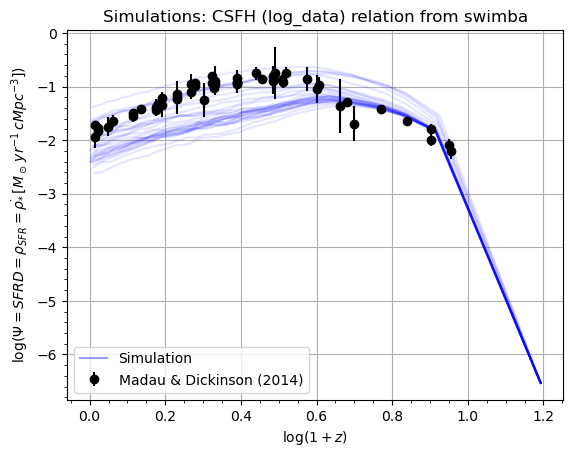

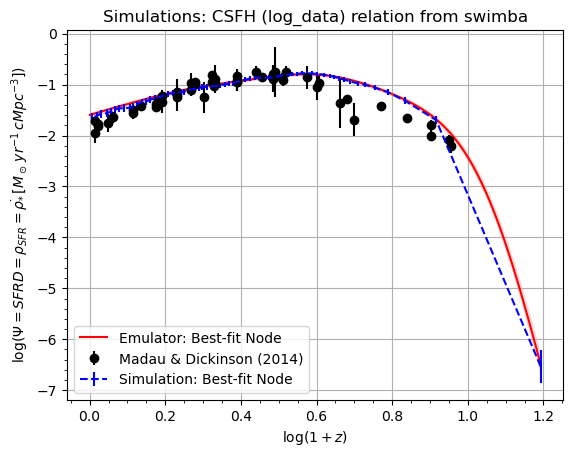

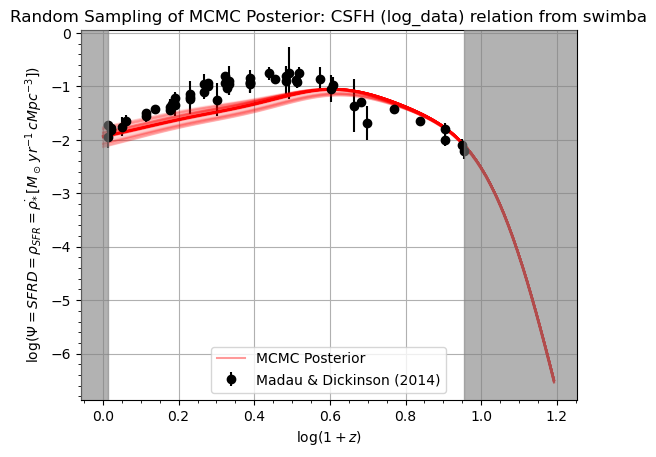

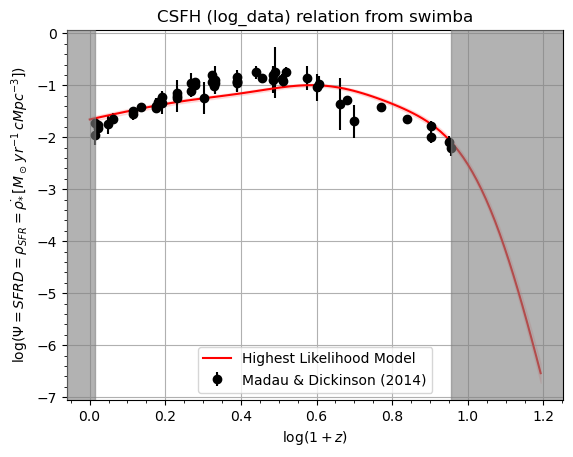

In [43]:
shade_intensity = 0.6
zorder = 4

for key, item in emulator_info_extra.items():
    print(key)
    print()
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']
    
    
    # Plot simulated observables over observational data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
        
    for cali, cali_item in item['emulator'].model_values.items():
        sim_x_cali = cali_item['independent']
        sim_y_cali = cali_item['dependent']

        plt.plot(sim_x_cali, sim_y_cali,
                 ls='-', marker=item['plot_sim']['marker'], color=item['plot_sim']['color'], alpha=0.1)

    plt.plot([],[], color=item['plot_sim']['color'], alpha=0.4, label='Simulation')
    
    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Plot best-fit simulation node over observational data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
#     plt.errorbar(item['data_lim'][0], item['data_lim'][1], yerr=item['data_lim'][2], 
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                  label=item['observational_data'].citation)
    
    pred_y, pred_err = emulator_model(pred_x, item['params_best_node'], item['emulator'])
#     plt.errorbar(pred_x, pred_y, yerr=pred_err, ls='-', label='Emulator: Best-fit Node')
    plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node', 
             color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
    plt.errorbar(item['emulator'].model_values[item['best_node']]['independent'], 
                 item['emulator'].model_values[item['best_node']]['dependent'],
                 item['emulator'].model_values[item['best_node']]['dependent_error'],
                 label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
                 ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    
    # Extract random sampling of posteriors and plot over data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
    
    for theta in flat_samples[np.random.randint(len(flat_samples), size=100)]:
        pred_mcmc, pred_mcmc_err = model(theta, pred_x, item['emulator'])
        plt.plot(pred_x, pred_mcmc, color=item['plot_emu']['color'], 
                 ls='-', marker=item['plot_emu']['marker'], alpha=0.1)

    plt.plot([],[], color=item['plot_emu']['color'], alpha=0.4, label='MCMC Posterior')
    
    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Random Sampling of MCMC Posterior: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Posterior parameters with highest probability
    best_fit_model, best_fit_model_err = model(theta_max_arr, pred_x, item['emulator'])

#     theta_max = {}
#     for param in emulator.parameter_order:
#         idx = item['emulator'].parameter_order.index(param)
#         theta_max[param] = theta_max_arr[idx]
    
#     item['theta_max_arr'] = theta_max_arr
#     item['theta_max'] = theta_max
#     print ('Theta max: ', theta_max)
    
    
    
    # Plot best-fit model over data
    plt.clf()
    plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                 label=item['observational_data'].citation)
    
#     plt.errorbar(pred_x, best_fit_model, yerr=best_fit_model_err,
#                  color="r", alpha=1, label='Highest Likelihood Model')
    plt.plot(pred_x, best_fit_model, label='Highest Likelihood Model', 
             color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    plt.fill_between(pred_x, best_fit_model-best_fit_model_err, best_fit_model+best_fit_model_err, 
                     alpha=0.1, color=item['plot_emu']['color'])

    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title( item['emulator'].model_specification.sim_info['name'])
    
#     if key=='CSFH':
#         plt.ylim(-3, 0)
    
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    print()
    print()
    print()